## 1 Data preparation & cleaning

### Loading libraries and file

In [1]:

import datetime as dt
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import h2o
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from math import radians, sin, cos, sqrt, atan2
from shapely.geometry import Polygon
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from statsmodels.tools.tools import add_constant

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from h2o.automl import H2OAutoML
from tpot import TPOTClassifier
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import r2_score
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from sklearn.linear_model import LinearRegression 
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
import sys
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from matplotlib.ticker import FuncFormatter
import random
from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer



In [2]:
# read the file
accidents_sub = pd.read_csv('./dataset/US_Accidents_March23.csv')
accidents_sub.shape

(7728394, 46)

In [3]:
# check numeric features
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = accidents_sub.select_dtypes(include=numerics)
print("There are", len(numeric_df.columns), "numeric columns.")

There are 13 numeric columns.


## 2. Exploratory Data Analysis

### Modify some information for the data and the columns

In [4]:
# change format of time from FLOAT to DATE 
accidents_sub['Start_Time'] = pd.to_datetime(accidents_sub["Start_Time"], errors="coerce")
accidents_sub['End_Time'] = pd.to_datetime(accidents_sub["End_Time"], errors="coerce")
# Add new column YEAR, MONTH , DAY and Hour ... to create new features  
accidents_sub["Start_Year"]=accidents_sub["Start_Time"].dt.year
accidents_sub["Start_Hour"]=accidents_sub["Start_Time"].dt.hour
accidents_sub["Start_Month"]=accidents_sub["Start_Time"].dt.month
accidents_sub["Start_Day"]=accidents_sub["Start_Time"].dt.day_name()

In [5]:
# Remove the following unneeded columns since they are not going to be used for eda for sure   
accidents_sub = accidents_sub.drop(['ID','Source', 'Street', 'Zipcode', 'County','Country'], axis =1 )


In [ ]:
# # Add new column Delay in min which is duration between start and end time
# accidents_sub["Delay_min"]=accidents_sub["End_Time"] - accidents_sub["Start_Time"]
# accidents_sub["Delay_min"]=accidents_sub["Delay_min"].apply(lambda x: x.total_seconds() / 60)
# # accidents_sub["Delay"]

# # Add new column Weekend 
# accidents_sub["Is_Weekend"] = accidents_sub["Start_Day"].isin(["Saturday", "Sunday"])

In [6]:
# check modified data frame after removing and adding 6 features accordingly 
accidents_sub.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,City,...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Start_Year,Start_Hour,Start_Month,Start_Day
0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,Dayton,...,False,False,Night,Night,Night,Night,2016,5,2,Monday
1,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Reynoldsburg,...,False,False,Night,Night,Night,Day,2016,6,2,Monday
2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,Williamsburg,...,True,False,Night,Night,Day,Day,2016,6,2,Monday
3,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,Dayton,...,False,False,Night,Day,Day,Day,2016,7,2,Monday
4,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Dayton,...,True,False,Day,Day,Day,Day,2016,7,2,Monday


### Yearly overview of accidents for given data

In [7]:
# prepare query to analyze number of accidents over the all years
year_df = pd.DataFrame(accidents_sub['Start_Year'].value_counts()).reset_index().sort_values(by='Start_Year', ascending=True)
year = year_df.rename(columns={'index':'year','Start_Year':'cases'})

C:\Users\st123\AppData\Local\Temp\ipykernel_15064\549144554.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year.year, y=year.cases, palette=colors)


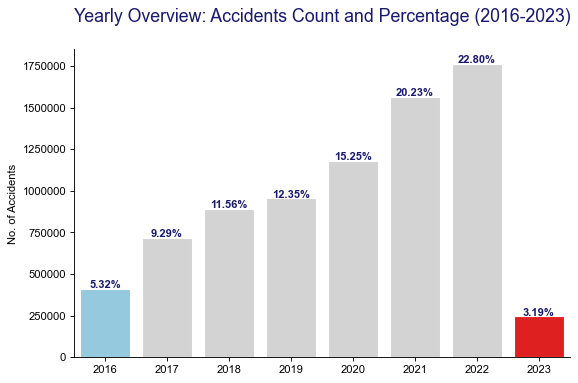

In [8]:
# distribution of road accidents are as follows
fig, ax = plt.subplots(figsize = (8,5), dpi = 80)
sns.set_style('ticks') # style must be one of white, dark, whitegrid, darkgrid, ticks 

# Determine the colors (as before)
colors = ['red' if val == max(year['cases']) else 'skyblue' if val == min(year['cases']) else 'lightgrey' for val in year['cases']]

sns.barplot(x=year.year, y=year.cases, palette=colors)
ax.spines[('top')].set_visible(False)
ax.spines[('right')].set_visible(False)
ax.set_xlabel(None)
ax.set_ylabel("No. of Accidents")
ax.set_title('Yearly Overview: Accidents Count and Percentage (2016-2023)\n', fontdict = {'fontsize':16 , 'color':'MidnightBlue'})

# Customize Y-axis tick labels to show real numbers
def format_func(value, _):
    return f'{value:.0f}'  # Format as whole numbers
ax.yaxis.set_major_formatter(FuncFormatter(format_func))
total_accidents = accidents_sub.shape[0]
for p in ax.patches :
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2,
            height + 5000,
            '{:.2f}%'.format(height/total_accidents*100),
            ha = "center",
            fontsize = 10, weight='bold', color='MidnightBlue')

for i in ['top','right']:
    side = ax.spines[i]
    side.set_visible(False)

plt.show()

## 3. Data Engineering 

Let us to select last 3 years in order to make data set smaller and testing with recent data (it covers more 60% of all data)  

In [9]:
# accidents_sub = accidents_sub[accidents_sub["Start_Year"]>2020]
accidents_sub = accidents_sub[(accidents_sub["Start_Year"] >= 2020) & (accidents_sub["Start_Year"] <= 2023)]

In [10]:
# check the size of the reduced data set
accidents_sub.shape

(4751751, 44)

In [11]:
unique_values_per_column = accidents_sub.nunique()
print(unique_values_per_column)

Severity                       4
Start_Time               3056401
End_Time                 3699935
Start_Lat                1736522
Start_Lng                1779752
End_Lat                  1335536
End_Lng                  1358950
Distance(mi)               20884
Description              2353754
City                       12450
State                         49
Timezone                       4
Airport_Code                1989
Weather_Timestamp         470499
Temperature(F)               177
Wind_Chill(F)                194
Humidity(%)                  100
Pressure(in)                1094
Visibility(mi)                51
Wind_Direction                18
Wind_Speed(mph)               93
Precipitation(in)            235
Weather_Condition            111
Amenity                        2
Bump                           2
Crossing                       2
Give_Way                       2
Junction                       2
No_Exit                        2
Railway                        2
Roundabout

In [12]:
# let's define unique values and nature of each feature
unique_values_in_dataset = accidents_sub.apply(lambda x: x.unique())
print(unique_values_in_dataset)

Severity                                                      [1, 2, 3, 4]
Start_Time               [2022-09-08T05:49:30.000000000, 2022-09-08T02:...
End_Time                 [2022-09-08T06:34:53.000000000, 2022-09-08T04:...
Start_Lat                [41.946796, 34.521172, 37.542839, 40.896629, 4...
Start_Lng                [-88.20809200000002, -117.958076, -77.44178000...
End_Lat                  [nan, 45.666976, 41.39837, 40.846945, 33.71453...
End_Lng                  [nan, -94.176184, -75.48420300000002, -73.9336...
Distance(mi)             [0.0, 1.9099999666213991, 1.5900000333786009, ...
Description              [Crash on CR-11 Army Trail Rd at IL-59., Crash...
City                     [Bartlett, Littlerock, Richmond, Alliance, Ind...
State                    [IL, CA, VA, OH, PA, SC, NJ, NY, FL, NC, TX, A...
Timezone                 [US/Central, US/Pacific, US/Eastern, US/Mounta...
Airport_Code             [KDPA, KPMD, KRIC, KCAK, KBKL, KTHV, KTZR, KCM...
Weather_Timestamp        

In [13]:
for column in accidents_sub.columns:
    print(accidents_sub[column].value_counts())

2    4161669
3     411394
4     112291
1      66397
Name: Severity, dtype: int64
2021-01-26 16:16:13    253
2021-01-26 16:17:33    170
2021-02-16 06:42:43    157
2021-11-21 18:37:51    125
2020-12-16 13:53:25     99
                      ... 
2020-06-16 19:32:28      1
2020-06-16 19:32:06      1
2020-06-16 19:30:28      1
2020-06-16 19:33:33      1
2020-01-01 00:31:17      1
Name: Start_Time, Length: 3056401, dtype: int64
2021-11-22 08:00:00    129
2020-02-14 00:00:00     46
2021-06-09 20:23:43     42
2020-02-12 00:00:00     42
2021-07-12 23:41:50     41
                      ... 
2022-10-07 16:54:56      1
2022-03-04 17:47:42      1
2022-06-19 04:26:31      1
2022-09-14 08:14:15      1
2020-01-01 00:59:51      1
Name: End_Time, Length: 3699935, dtype: int64
34.858849    544
25.964170    359
25.702455    358
28.451602    355
27.447751    350
            ... 
36.672119      1
36.639610      1
29.909071      1
35.945362      1
38.840700      1
Name: Start_Lat, Length: 1736522, dtype: int

Initial ObServation shows some features are dominated by single value thus variety is presented by 1% or even less, 
for example:

Name: Roundabout, domination of one variable value: True is 0.003% -
False    4751606
True         145

Name: Bump, domination of one variable value: True is 0.05% -
False    4749253
True        2498 

Name: Traffic_Calming, domination of one variable value: True is 0.1% -
False    4746794
True        4957

Name: Weather_Condition - 
Heavy Sleet / Windy                1
Sand / Windy                       1
Heavy Rain Shower / Windy          1
Blowing Snow Nearby                1
Drifting Snow                      1


In [14]:
accidents_sub.head()

,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,City,...,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Start_Year,Start_Hour,Start_Month,Start_Day
512217,1,2022-09-08 05:49:30,2022-09-08 06:34:53,41.946796,-88.208092,NaN,NaN,0.00,Crash on CR-11 Army Trail Rd at IL-59.,Bartlett,...,True,False,Night,Night,Day,Day,2022,5,9,Thursday
512218,1,2022-09-08 02:02:05,2022-09-08 04:31:32,34.521172,-117.958076,NaN,NaN,0.00,Crash on CA-138 Pearblossom Hwy at 96th St.,Littlerock,...,False,False,Night,Night,Night,Night,2022,2,9,Thursday
512219,1,2022-09-08 05:14:12,2022-09-08 07:38:17,37.542839,-77.441780,NaN,NaN,0.00,Crash on 2nd St Northbound at Franklin St.,Richmond,...,True,False,Night,Night,Night,Night,2022,5,9,Thursday
512220,1,2022-09-08 06:22:57,2022-09-08 06:52:42,40.896629,-81.178452,NaN,NaN,0.00,Crash on US-62 Atlantic Blvd Westbound after O...,Alliance,...,False,False,Night,Night,Day,Day,2022,6,9,Thursday
512221,2,2022-09-08 06:36:20,2022-09-08 07:05:58,41.409359,-81.644318,NaN,NaN,1.91,Crash on entry ramp to I-77 Northbound at Exit...,Independence,...,False,False,Night,Day,Day,Day,2022,6,9,Thursday


In [15]:
accidents_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4751751 entries, 512217 to 7246341
Data columns (total 44 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   Severity               int64         
 1   Start_Time             datetime64[ns]
 2   End_Time               datetime64[ns]
 3   Start_Lat              float64       
 4   Start_Lng              float64       
 5   End_Lat                float64       
 6   End_Lng                float64       
 7   Distance(mi)           float64       
 8   Description            object        
 9   City                   object        
 10  State                  object        
 11  Timezone               object        
 12  Airport_Code           object        
 13  Weather_Timestamp      object        
 14  Temperature(F)         float64       
 15  Wind_Chill(F)          float64       
 16  Humidity(%)            float64       
 17  Pressure(in)           float64       
 18  Visibility(mi)   

 Stats Distribution

In [16]:
accidents_sub.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Start_Year,Start_Hour,Start_Month
count,4.751751e+06,4.751751e+06,4.751751e+06,3.595240e+06,3.595240e+06,4.751751e+06,4.643873e+06,4.606635e+06,4.636693e+06,4.659125e+06,4.640264e+06,4.621585e+06,4.548062e+06,4.751751e+06,4.751751e+06,4.751751e+06
mean,2.119867e+00,3.601684e+01,-9.424960e+01,3.599296e+01,-9.486553e+01,7.349116e-01,6.123374e+01,5.994121e+01,6.446963e+01,2.935496e+01,9.052302e+00,7.349406e+00,5.803461e-03,2.021227e+03,1.246597e+01,6.481211e+00
std,4.250981e-01,5.163296e+00,1.748346e+01,5.285267e+00,1.792230e+01,1.885829e+00,1.914043e+01,2.131319e+01,2.297849e+01,1.110632e+00,2.550064e+00,5.547325e+00,5.200175e-02,8.804931e-01,5.679916e+00,3.737475e+00
min,1.000000e+00,2.455480e+01,-1.245481e+02,2.456601e+01,-1.245457e+02,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.020000e+03,0.000000e+00,1.000000e+00
25%,2.000000e+00,3.312941e+01,-1.171799e+02,3.304288e+01,-1.174662e+02,0.000000e+00,4.800000e+01,4.700000e+01,4.800000e+01,2.917000e+01,1.000000e+01,3.000000e+00,0.000000e+00,2.021000e+03,8.000000e+00,3.000000e+00
50%,2.000000e+00,3.580159e+01,-8.673347e+01,3.590953e+01,-8.677518e+01,1.420000e-01,6.300000e+01,6.300000e+01,6.700000e+01,2.969000e+01,1.000000e+01,7.000000e+00,0.000000e+00,2.021000e+03,1.300000e+01,6.000000e+00
75%,2.000000e+00,3.997373e+01,-8.023257e+01,3.998256e+01,-8.018690e+01,7.640000e-01,7.600000e+01,7.600000e+01,8.400000e+01,2.996000e+01,1.000000e+01,1.000000e+01,0.000000e+00,2.022000e+03,1.700000e+01,1.000000e+01
max,4.000000e+00,4.900050e+01,-6.748413e+01,4.900222e+01,-6.748413e+01,4.417500e+02,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,3.647000e+01,2.023000e+03,2.300000e+01,1.200000e+01


Stats Distribution and variability of the data

o	Over 75% of accident visibility is 10 miles or less. (Even at 25%, it's still 10 Miles or less, showing the concentration of the distribution towards one point).

o	The temperature has a mean of 61.2° F, with a range of [-89 , 207]. Beyond that, with a std of 19.1, we can assume a fairly wide temperature variability for the United States.

o	More than 75% of wind speeds are at 10 mph or less, but there are instances of extreme wind 1087 mph, which can seriously affect accidents.


## 4. Data Design and Visualization 

### Average Monthly Accidents

C:\Users\st123\AppData\Local\Temp\ipykernel_15064\3997322216.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month.month_name, y=month.cases, palette=colors)


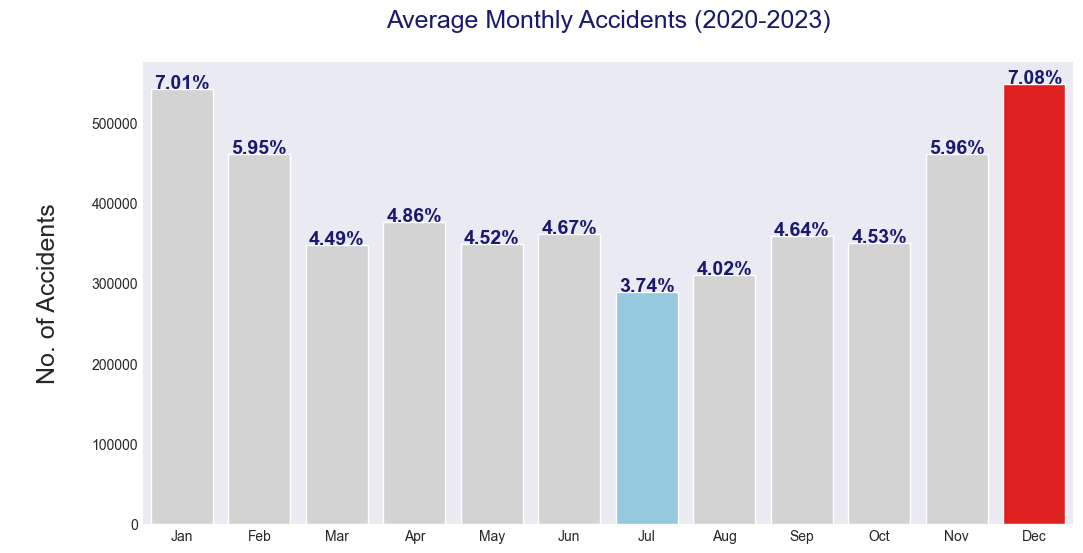

In [17]:
month_df = pd.DataFrame(accidents_sub.Start_Time.dt.month.value_counts()).reset_index()
month = month_df.rename(columns={'index':'Start_month#','Start_Time':'cases'}).sort_values(by='Start_month#', ascending=True)

# adding month name as a column
month_map = {1:'Jan' , 2:'Feb' , 3:'Mar' , 4:'Apr' , 5:'May' , 6:'Jun', 7:'Jul' , 8:'Aug', 9:'Sep',10:'Oct' , 11:'Nov' , 12:'Dec'}
month['month_name'] = month['Start_month#'].map(month_map)

# ===========================================================
plt.style.use('seaborn-v0_8-dark')
fig, ax = plt.subplots(figsize = (12,6), dpi = 100)
sns.set_style('ticks')

# Determine the colors (as before)
colors = ['red' if val == max(month['cases']) else 'skyblue' if val == min(month['cases']) else 'lightgrey' for val in month['cases']]

sns.barplot(x=month.month_name, y=month.cases, palette=colors)

ax.set_title('Average Monthly Accidents (2020-2023)\n', fontdict = {'fontsize':18 , 'color':'MidnightBlue'})
ax.set_ylabel("\nNo. of Accidents\n", fontsize = 18)
ax.set_xlabel(None)

# Customize Y-axis tick labels to show real numbers
def format_func(value, _):
    return f'{value:.0f}'  # Format as whole numbers
ax.yaxis.set_major_formatter(FuncFormatter(format_func))

for p in ax.patches :
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2,
            height + 1000,
            '{:.2f}%'.format(height/total_accidents*100),
            ha = "center",
            fontsize = 14, weight='bold', color='MidnightBlue')
for i in ['top', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
plt.show()

Observation - Surprisingly behaviour in July is low (it is explained by epidem period in COVID break)

### Average per day of week Accidents

C:\Users\st123\AppData\Local\Temp\ipykernel_15064\2235287897.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax=sns.barplot(y=dow.cases, x=dow.weekday, palette='pastel')


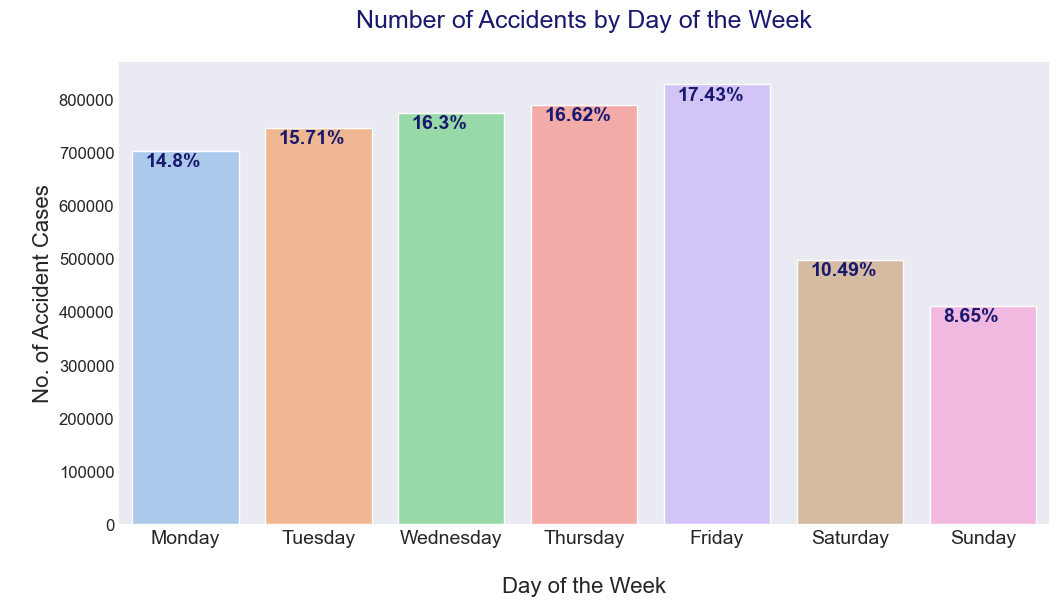

In [18]:
dow = pd.DataFrame(accidents_sub['Start_Time'].dt.dayofweek.value_counts()).reset_index()
dow = dow.rename(columns={'index':'day_of_week', 'Start_Time':'cases'}).sort_values(by='day_of_week')
day_map = {0:'Monday' , 1:'Tuesday' , 2:'Wednesday' , 3:"Thursday" , 4:'Friday' , 5:"Saturday" , 6:'Sunday'}   
dow['weekday'] = dow['day_of_week'].map(day_map)

# ===========================================================
plt.style.use('seaborn-v0_8-dark')
fig, ax = plt.subplots(figsize = (12,6), dpi = 100)
sns.set_style('ticks') 

ax=sns.barplot(y=dow.cases, x=dow.weekday, palette='pastel')
plt.title('Number of Accidents by Day of the Week\n', size=18, color='MidnightBlue')
plt.ylabel('\nNo. of Accident Cases', fontsize=16)
plt.xlabel('\nDay of the Week', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)

total = accidents_sub.shape[0]
for i in ax.patches:
    ax.text(i.get_x()+0.1, i.get_height()-20000,
    str(round((i.get_height()/total)*100, 2))+'%',
    va = "center", fontsize=14, weight='bold', color='MidnightBlue')

for i in ['top', 'right']:
    side = ax.spines[i]
    side.set_visible(False)

# Customize Y-axis tick labels to show real numbers
def format_func(value, _):
    return f'{value:.0f}'  # Format as whole numbers
ax.yaxis.set_major_formatter(FuncFormatter(format_func))

plt.show()

Observation: Surprising behaviour on Sunday and Saturday (explained with obvious evidence less trafic in weekend)

### Average per Hour of Day Accidents

C:\Users\st123\AppData\Local\Temp\ipykernel_15064\2225894603.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hour_of_day.hour, y=hour_of_day.cases, palette=colors)


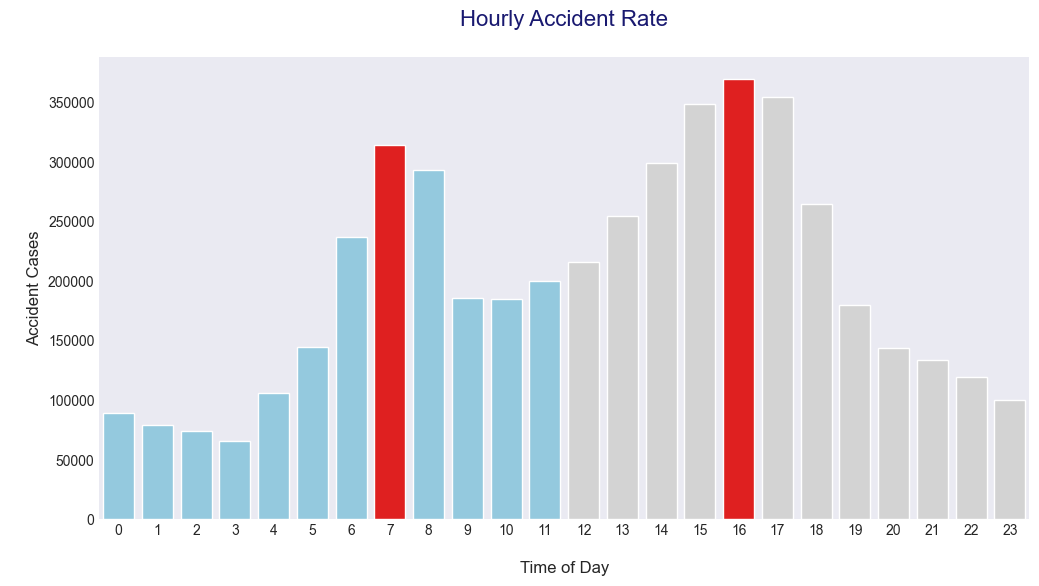

In [19]:

hour_of_day = pd.DataFrame(accidents_sub['Start_Hour'].value_counts()).reset_index().rename(columns={'index':'hour','Start_Hour':'cases'})
hour_of_day.sort_values(by='hour', inplace=True)
# hour_of_day
# ===========================================================
plt.style.use('seaborn-v0_8-dark')
fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
sns.set_style('ticks')
colors = []
for x in hour_of_day['cases']:
    if int(hour_of_day[hour_of_day['cases'] == x]['hour']) <=11:
        if x == max(list(hour_of_day['cases'])[:12]):
            colors.append('red')
        else:
            colors.append('skyblue')
    else:
        if x == max(list(hour_of_day['cases'])[12:]):
            colors.append('red')
        else:
            colors.append('lightgrey') 

# Create a bar plot of 'hourly_accident_rate'
sns.barplot(x=hour_of_day.hour, y=hour_of_day.cases, palette=colors)

plt.title('Hourly Accident Rate\n', size=16, color='MidnightBlue')
plt.ylabel('\nAccident Cases', fontsize=12)
plt.xlabel('\nTime of Day', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

for i in ['top', 'right']:
    side = ax.spines[i]
    side.set_visible(False)

plt.show()

Observation: the most frequent hours for accidents fall just before regular office hours start or end (before trafic jam)

### What is the most frequent weather conditions for accidents

In [20]:
# wc stands for weather condition, let's find key words for each condition
accidents_sub.loc[accidents_sub["Weather_Condition"].str.contains("Thunder|T-Storm", na=False), "Weather_Condition"] = "Thunderstorm"
accidents_sub.loc[accidents_sub["Weather_Condition"].str.contains("Snow|Sleet|Wintry", na=False), "Weather_Condition"] = "Snow"
accidents_sub.loc[accidents_sub["Weather_Condition"].str.contains("Rain|Drizzle|Shower", na=False), "Weather_Condition"] = "Rain"
accidents_sub.loc[accidents_sub["Weather_Condition"].str.contains("Wind|Squalls", na=False), "Weather_Condition"] = "Windy"
accidents_sub.loc[accidents_sub["Weather_Condition"].str.contains("Hail|Pellets", na=False), "Weather_Condition"] = "Hail"
accidents_sub.loc[accidents_sub["Weather_Condition"].str.contains("Fair", na=False), "Weather_Condition"] = "Clear"
accidents_sub.loc[accidents_sub["Weather_Condition"].str.contains("Cloud|Overcast", na=False), "Weather_Condition"] = "Cloudy"
accidents_sub.loc[accidents_sub["Weather_Condition"].str.contains("Mist|Haze|Fog", na=False), "Weather_Condition"] = "Fog"
accidents_sub.loc[accidents_sub["Weather_Condition"].str.contains("Sand|Dust", na=False), "Weather_Condition"] = "Sand"
accidents_sub.loc[accidents_sub["Weather_Condition"].str.contains("Smoke|Volcanic Ash", na=False), "Weather_Condition"] = "Smoke"
accidents_sub.loc[accidents_sub["Weather_Condition"].str.contains("N/A Precipitation", na=False), "Weather_Condition"] = np.nan

C:\Users\st123\AppData\Local\Temp\ipykernel_15064\2781335697.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='weather_condition', data=wc, palette='cividis', orient='h')


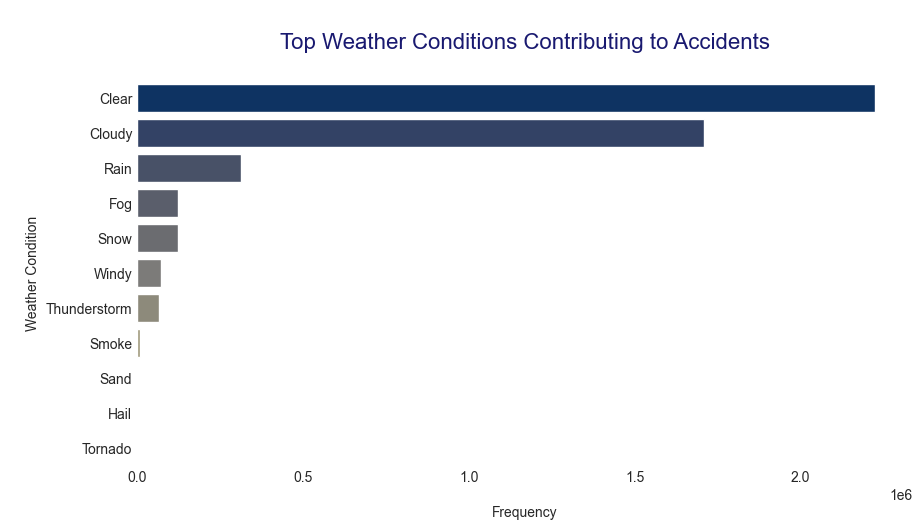

In [21]:
wc = pd.DataFrame(accidents_sub['Weather_Condition'].value_counts()).reset_index().sort_values(by='Weather_Condition', ascending=False)
wc.rename(columns={'index':'weather_condition', 'Weather_Condition':'frequency'}, inplace=True)

# data = accidents_sub['Weather_Condition'].sum().sort_values(ascending=False)
# ===========================================================================
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 5))
sns.set_style('ticks')
sns.barplot(x='frequency', y='weather_condition', data=wc, palette='cividis', orient='h')
# sns.barplot(x=data.values, y=data.index, orient="h", hue=data.index, palette='cividis', legend=False)

# Add labels and title
ax.set_xlabel('\nFrequency')
ax.set_ylabel('\nWeather Condition')
ax.set_title('\nTop Weather Conditions Contributing to Accidents\n', fontsize=16, color='MidnightBlue')
plt.xticks(rotation=0)  # Adjust the rotation angle of x-axis labels

# Increase the font size of the axis tick labels
sns.set(rc={'xtick.labelsize': 10, 'ytick.labelsize': 10})

# Remove top and right spines
for i in ['top', 'right']:
    ax.spines[i].set_visible(False)

# Show the plot
plt.show()

Observation: Surprising fact most accidents happen at the sunny days and low correlation with bad weather curcumstances 

### What is the most frequent road conditions for accidents

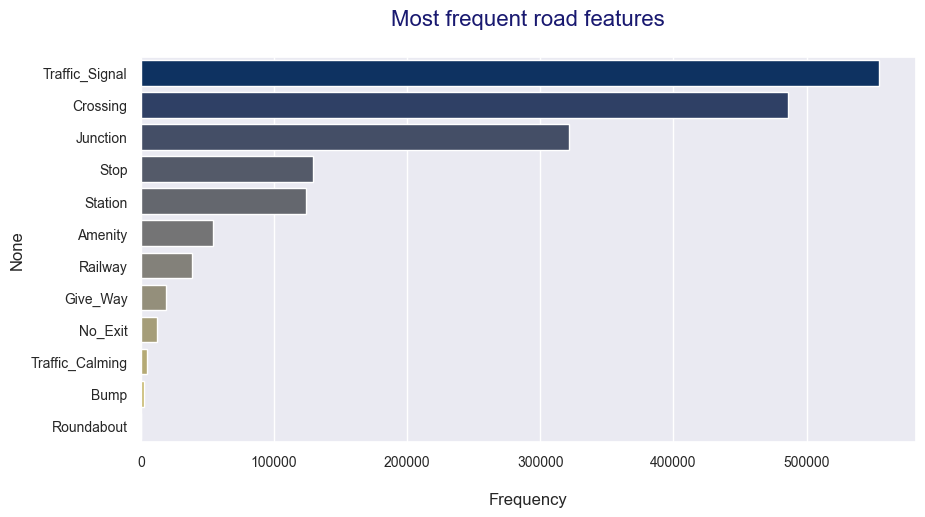

In [22]:
road_features = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal"]

data = accidents_sub[road_features].sum().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,5))
# sns.barplot(x=data.values, y=data.index, orient="h", palette='cividis')
sns.barplot(x=data.values, y=data.index, orient="h", hue=data.index, palette='cividis', legend=False)

plt.title("Most frequent road features\n", fontsize=16, color='MidnightBlue')
plt.xlabel("\nFrequency")

plt.show()

Observation: Surprising fact most accidents happen at the sunny days and low correlation with bad weather curcumstances 

### What description says about accident? 

In [23]:
import nltk
import random
from nltk.corpus import stopwords
stop = stopwords.words("english") + ["-"]
nltk.download("stopwords")
# stop_words=stopwords.words("english")
# new_stopping_words = stop_words[:len(stop_words)-36]
# new_stopping_words.remove("not")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\st123\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
# let us find key words from description for accident with severity 4 (most higher for importance)
description_s4 = accidents_sub[accidents_sub["Severity"] == 4]["Description"] # filter the key data
# Split the description
df_words = description_s4.str.lower().str.split(expand=True).stack()

In [25]:
# If the word is not in the stopwords list
counts = df_words[~df_words.isin(stop)].value_counts()[:10]
print(counts)

road         72352
closed.      67679
closed       50874
near         50257
due          45768
alternate    44292
route.       43916
take         43274
incident     42285
rd           32325
dtype: int64


C:\Users\st123\AppData\Local\Temp\ipykernel_15064\2058021307.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, orient="h", palette = "cividis")


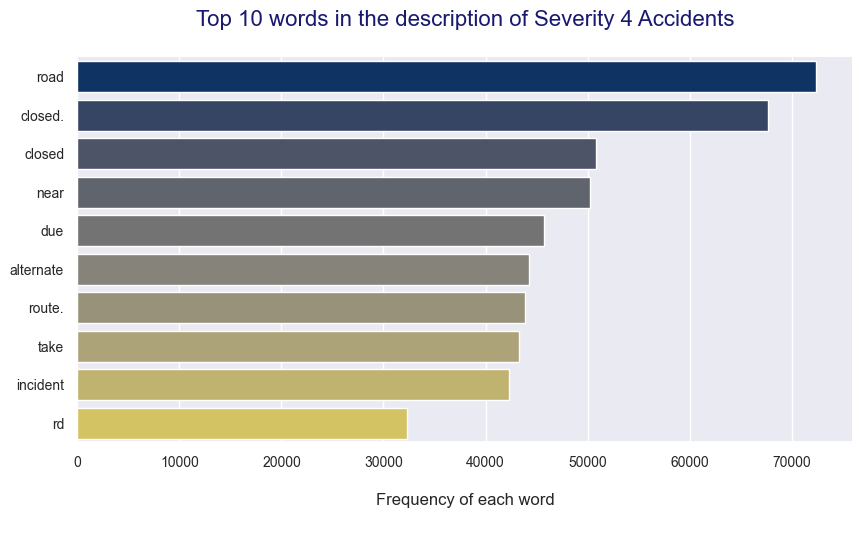

In [26]:
# visualize the frequencies of the top 10 words in the description
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
sns.set_style('ticks')
sns.barplot(x=counts.values, y=counts.index, orient="h", palette = "cividis")
# sns.barplot(x=counts.values, y=counts.index, orient="h")

ax.set_title("Top 10 words in the description of Severity 4 Accidents\n", fontsize=16, color='MidnightBlue')
ax.set_xlabel("\nFrequency of each word\n")
ax.set_ylabel(None)
for i in ['top', 'right']:
    side = ax.spines[i]
    side.set_visible(False)
plt.show()

Observation:- Obviously most accidents assosiated with closing Roads due to some reasons 

### What temperature says about accident? 

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
import matplotlib.font_manager as font_manager
from matplotlib import ticker
import matplotlib.font_manager as font_manager
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects

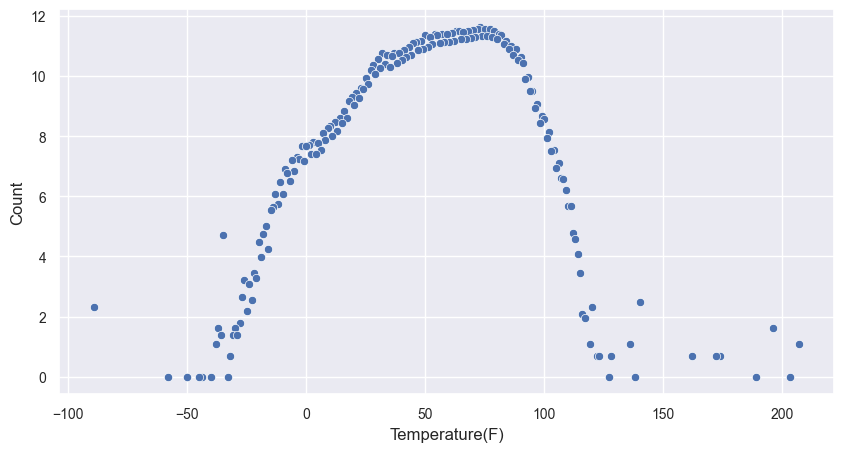

In [28]:
temp_counts = accidents_sub["Temperature(F)"].value_counts().reset_index()
temp_counts.columns = ["Temperature(F)", "Count"]
# temp_counts
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
# plt.xticks(filtered_df["Hour"].unique())
sns.scatterplot(temp_counts,x="Temperature(F)",y=temp_counts["Count"].apply(lambda x:math.log(x)))
plt.show()

In [29]:
crosstab=pd.crosstab(accidents_sub["Temperature(F)"],accidents_sub["Severity"])
crosstab

Severity,1,2,3,4
Temperature(F),,,,
-89.0,0,6,4,0
-58.0,0,1,0,0
-50.0,0,1,0,0
-45.0,0,1,0,0
-44.0,0,1,0,0
...,...,...,...,...
174.0,0,2,0,0
189.0,0,1,0,0
196.0,0,5,0,0


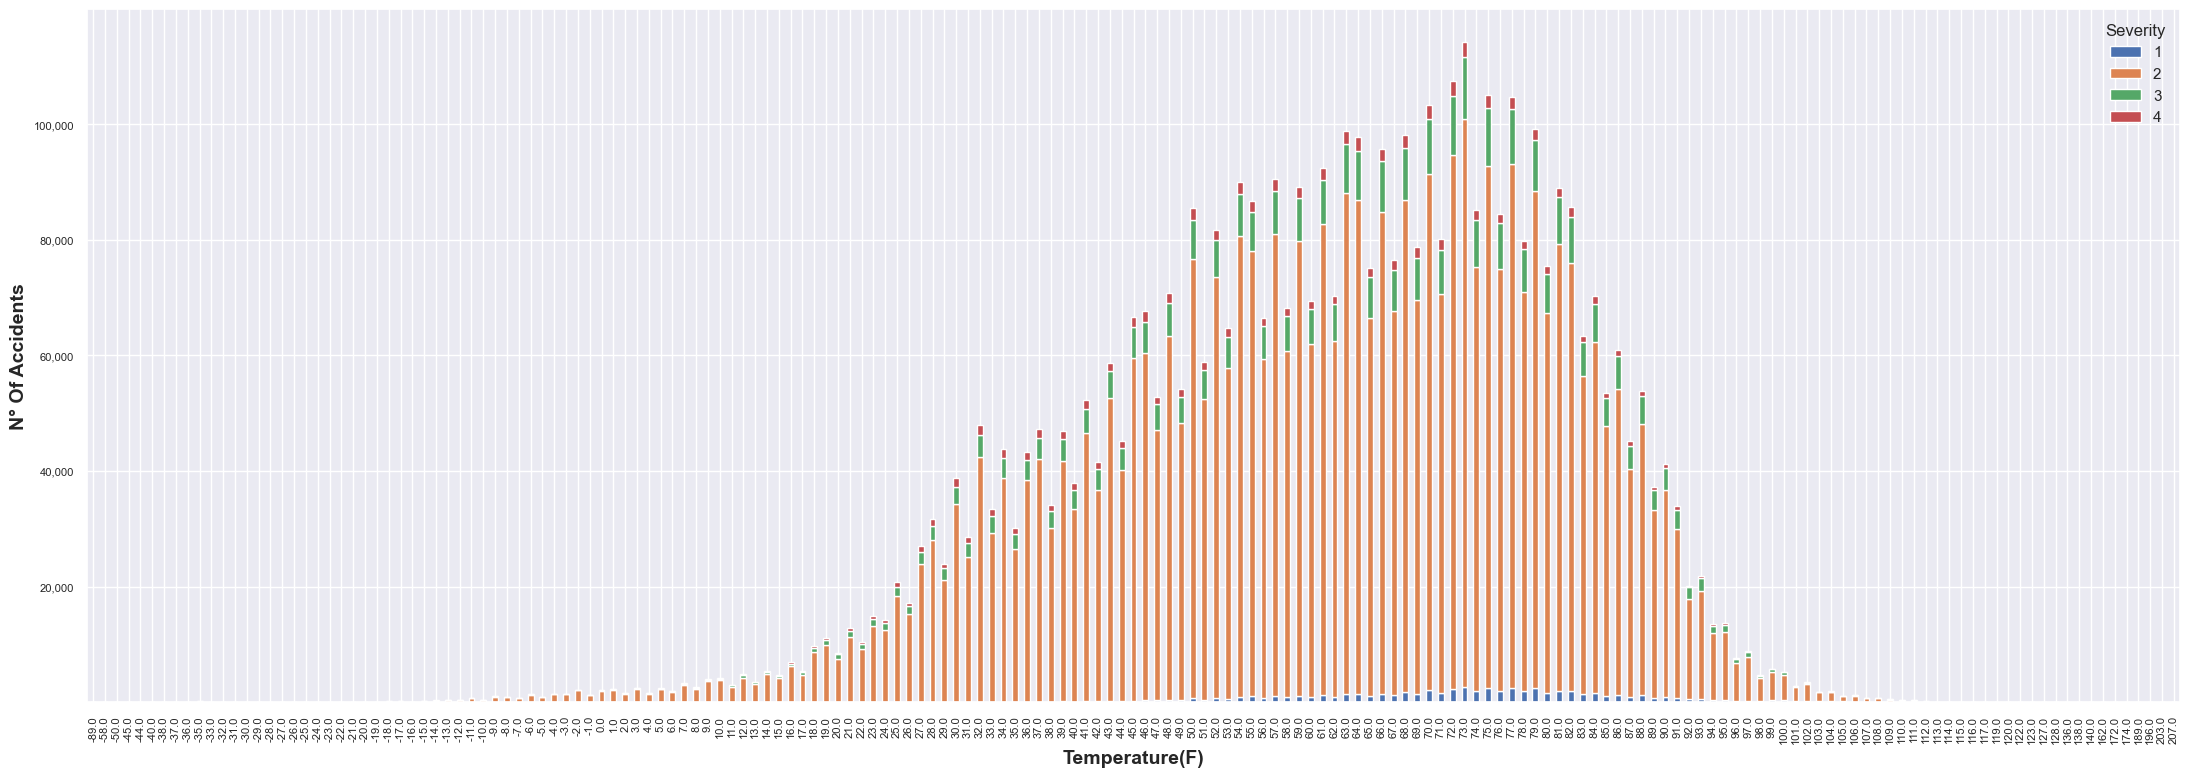

In [30]:
# sns.set_palette("Set2")
# sns.set_style('ticks')

crosstab.plot(kind="bar",stacked=True,
            figsize=(27,9),
            rot=90,
            fontsize=8
            )
label_font_bold = font_manager.FontProperties(weight='bold')
plt.xlabel("Temperature(F)",fontsize=14,fontproperties=label_font_bold)
plt.ylabel("N° Of Accidents",fontsize=14,fontproperties=label_font_bold)

formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

In [31]:
temp_of_day = pd.DataFrame(accidents_sub['Temperature(F)'].value_counts()).reset_index().rename(columns={'index':'Temperature','Temperature(F)':'cases'})
temp_of_day.sort_values(by='Temperature', inplace=True)
temp_of_day

,Temperature,cases
145,-89.0,10
167,-58.0,1
176,-50.0,1
172,-45.0,1
170,-44.0,1
...,...,...
160,174.0,2
174,189.0,1
150,196.0,5
175,203.0,1


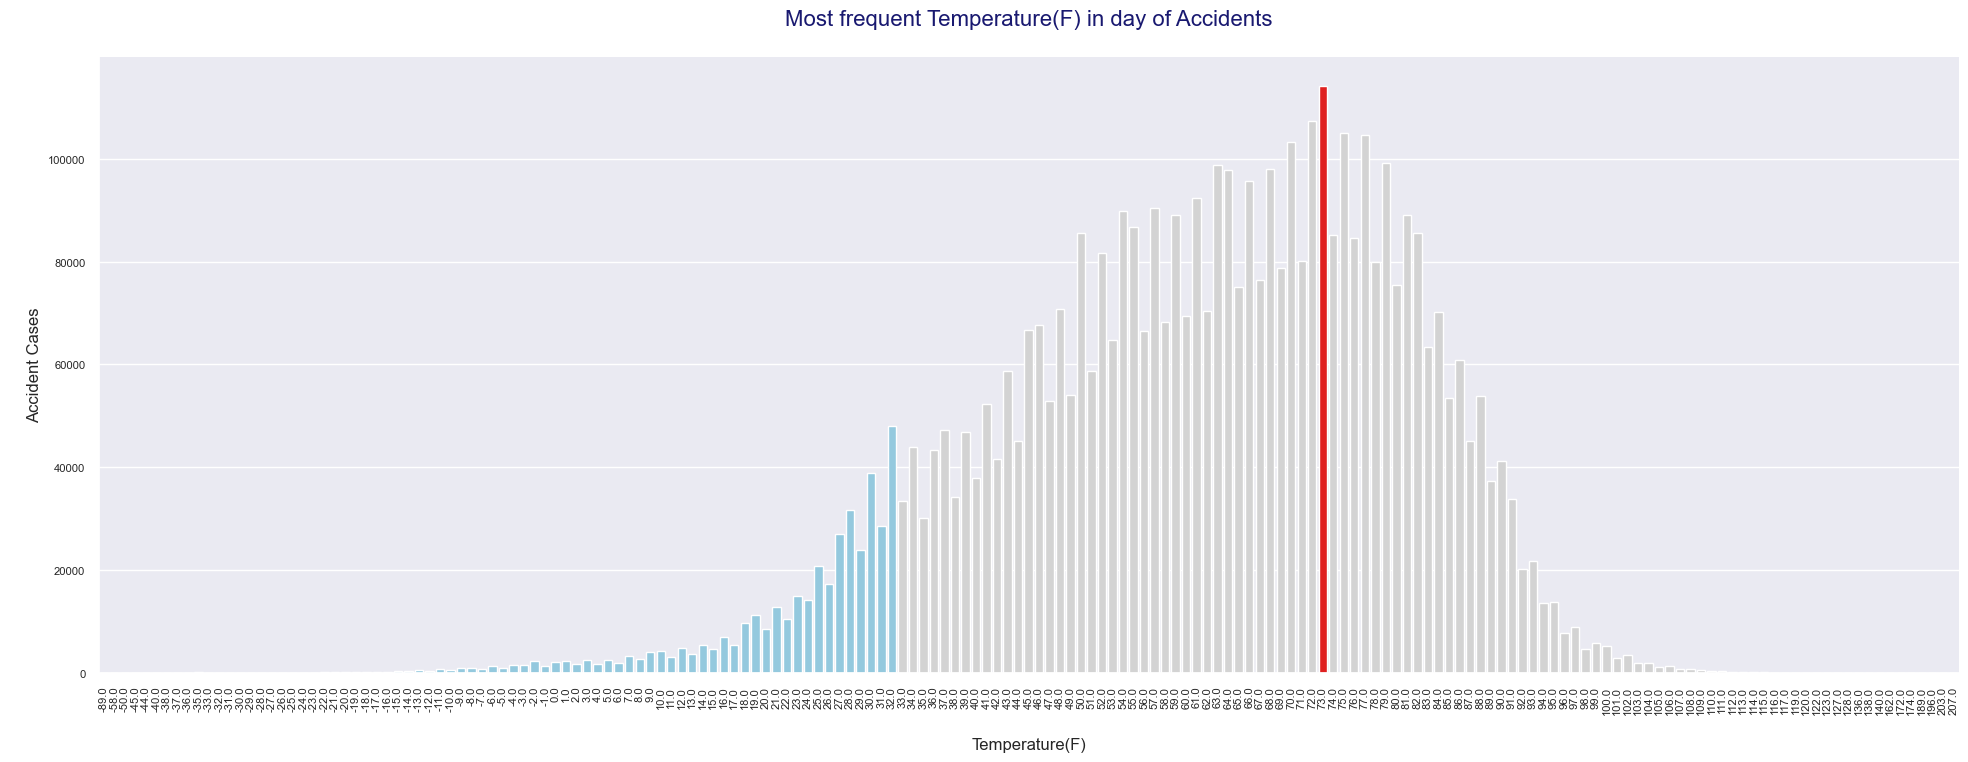

In [32]:
fig, ax = plt.subplots(figsize=(24,8), dpi=100)
sns.set_style('ticks')

colors = []
for x in temp_of_day['cases']:
    if int(temp_of_day[temp_of_day['cases'] == x]['Temperature'].iloc[0]) <=32:
        if x == max(list(temp_of_day['cases'])[:120]):
            colors.append('red')
        else:
            colors.append('skyblue')
    else:
        if x == max(list(temp_of_day['cases'])[100:]):
            colors.append('red')
        else:
            colors.append('lightgrey') 

# Create a bar plot of 'hourly_accident_rate'
sns.barplot(x=temp_of_day.Temperature, y=temp_of_day.cases, palette=colors)

plt.title('Most frequent Temperature(F) in day of Accidents\n', size=16, color='MidnightBlue')
plt.ylabel('\nAccident Cases', fontsize=12)
plt.xlabel('\nTemperature(F)', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

for i in ['top', 'right']:
    side = ax.spines[i]
    side.set_visible(False)

plt.show()

Observation: most accidents are happened at 73 Fahrenheit or 23 Celsius which is about almost room temperature  

## 5. Data Preprocessing

Imputation and missing values

In [33]:
# next steps about data imputation
accidents_sub.isnull().sum()

Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  1156511
End_Lng                  1156511
Distance(mi)                   0
Description                    4
City                         170
State                          0
Timezone                    4710
Airport_Code               17076
Weather_Timestamp          83638
Temperature(F)            107878
Wind_Chill(F)             145116
Humidity(%)               115058
Pressure(in)               92626
Visibility(mi)            111487
Wind_Direction            130210
Wind_Speed(mph)           130166
Precipitation(in)         203689
Weather_Condition         110655
Amenity                        0
Bump                           0
Crossing                       0
Give_Way                       0
Junction                       0
No_Exit                        0
Railway                        0
Roundabout

In [34]:
#filling missing values with interpolate method
# limit is Maximum number of consecutive NaNs to fill. Must be greater than 0.
accidents_sub.fillna(method='ffill', limit=5, inplace=True)
accidents_sub.fillna(method='bfill', limit=5, inplace=True)

In [35]:
accidents_sub.isnull().sum()

Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  1156506
End_Lng                  1156506
Distance(mi)                   0
Description                    0
City                           0
State                          0
Timezone                       0
Airport_Code                   0
Weather_Timestamp            961
Temperature(F)               968
Wind_Chill(F)                971
Humidity(%)                  968
Pressure(in)                 961
Visibility(mi)               961
Wind_Direction               964
Wind_Speed(mph)              964
Precipitation(in)           1361
Weather_Condition            961
Amenity                        0
Bump                           0
Crossing                       0
Give_Way                       0
Junction                       0
No_Exit                        0
Railway                        0
Roundabout

In [36]:
# remove rows with zero values
accidents_sub = accidents_sub.dropna()
missing_values = accidents_sub.isna()
missing_counts = accidents_sub.isna().sum()
total_missing = accidents_sub.isna().sum().sum()

In [37]:
accidents_sub.isnull().sum()

Severity                 0
Start_Time               0
End_Time                 0
Start_Lat                0
Start_Lng                0
End_Lat                  0
End_Lng                  0
Distance(mi)             0
Description              0
City                     0
State                    0
Timezone                 0
Airport_Code             0
Weather_Timestamp        0
Temperature(F)           0
Wind_Chill(F)            0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
Station                  0
Stop                     0
Traffic_Calming          0
Traffic_Signal           0
Turning_Loop             0
Sunrise_Sunset           0
C

Cleared data frame and statistics

In [38]:
accidents_sub.columns

Index(['Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'City', 'State',
       'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
       'Start_Year', 'Start_Hour', 'Start_Month', 'Start_Day'],
      dtype='object')

In [39]:
accidents_sub.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in),Start_Year,Start_Hour,Start_Month
count,3.595200e+06,3.595200e+06,3.595200e+06,3.595200e+06,3.595200e+06,3.595200e+06,3.595200e+06,3.595200e+06,3.595200e+06,3.595200e+06,3.595200e+06,3.595200e+06,3.595200e+06,3.595200e+06,3.595200e+06,3.595200e+06
mean,2.062069e+00,3.599279e+01,-9.486576e+01,3.599302e+01,-9.486537e+01,8.828053e-01,6.108479e+01,5.976274e+01,6.372479e+01,2.935432e+01,9.060771e+00,7.429183e+00,5.508962e-03,2.021365e+03,1.284385e+01,6.609678e+00
std,3.619444e-01,5.285052e+00,1.792273e+01,5.285289e+00,1.792234e+01,1.857249e+00,1.939736e+01,2.163662e+01,2.297815e+01,1.136505e+00,2.538379e+00,5.613030e+00,4.764102e-02,8.735475e-01,5.805648e+00,3.815319e+00
min,1.000000e+00,2.456603e+01,-1.245481e+02,2.456601e+01,-1.245457e+02,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.020000e+03,0.000000e+00,1.000000e+00
25%,2.000000e+00,3.304191e+01,-1.174668e+02,3.304331e+01,-1.174662e+02,7.500000e-02,4.800000e+01,4.600000e+01,4.700000e+01,2.918000e+01,1.000000e+01,3.000000e+00,0.000000e+00,2.021000e+03,8.000000e+00,3.000000e+00
50%,2.000000e+00,3.590953e+01,-8.677509e+01,3.590968e+01,-8.677517e+01,2.830000e-01,6.300000e+01,6.300000e+01,6.600000e+01,2.972000e+01,1.000000e+01,7.000000e+00,0.000000e+00,2.021000e+03,1.400000e+01,6.000000e+00
75%,2.000000e+00,3.998321e+01,-8.018832e+01,3.998258e+01,-8.018690e+01,9.690000e-01,7.600000e+01,7.600000e+01,8.300000e+01,2.997000e+01,1.000000e+01,1.000000e+01,0.000000e+00,2.022000e+03,1.700000e+01,1.000000e+01
max,4.000000e+00,4.900050e+01,-6.748413e+01,4.900222e+01,-6.748413e+01,1.551860e+02,2.070000e+02,2.070000e+02,1.000000e+02,5.863000e+01,1.400000e+02,1.087000e+03,2.400000e+01,2.023000e+03,2.300000e+01,1.200000e+01


## 6. Feature Selection

chosing most salient features for selected label

In [40]:
X = accidents_sub[['Start_Month', 'Start_Year', 'Start_Hour', 'Start_Lat', 'Temperature(F)', 'Wind_Speed(mph)', 'Distance(mi)']]
y = accidents_sub['Severity']
# df['column_name'] = pd.to_numeric(df['column_name'], errors='coerce')

splitting to train and test datasets

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

## 7. Model Selection

### Classification metrics

first of all we check classification accuraccy and confusion matrix for 3 models: Logistic Regression (LR), Random Forest (RF), Gradient boosting (GB)  

In [42]:
# Gradient boosting.....
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming you have your features in X and labels in y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Train the classifier
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}') 
print(classification_report(y_test, y_pred))

Accuracy: 0.95
              precision    recall  f1-score   support

           1       0.76      0.20      0.32      5604
           2       0.96      1.00      0.98    683609
           3       0.63      0.20      0.30      9227
           4       0.46      0.02      0.04     20600

    accuracy                           0.95    719040
   macro avg       0.70      0.36      0.41    719040
weighted avg       0.94      0.95      0.94    719040



In [43]:
# Random Forest (the most appropriate to our problem and it will be seen from the accuracy report)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more detailed metrics
print(classification_report(y_test, y_pred))


Accuracy: 0.95
              precision    recall  f1-score   support

           1       0.71      0.57      0.63      5604
           2       0.97      0.98      0.98    683609
           3       0.70      0.54      0.61      9227
           4       0.29      0.17      0.21     20600

    accuracy                           0.95    719040
   macro avg       0.67      0.57      0.61    719040
weighted avg       0.94      0.95      0.95    719040



In [44]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Create a logistic regression model
model = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=1000)

# Train the model on the training set
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# You can also print a classification report for more detailed metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.95
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      5604
           2       0.95      1.00      0.97    683609
           3       0.12      0.00      0.00      9227
           4       0.00      0.00      0.00     20600

    accuracy                           0.95    719040
   macro avg       0.27      0.25      0.24    719040
weighted avg       0.91      0.95      0.93    719040



Observation: preliminary validation using classification metrics shows better results for random forest algorythm  

### Cross validation

in order to that let us run cross validation of those 3 models and make sure that random forest is the most suitable model for our problem

In [45]:
# the list of algorithms for classification as Baselines are
from sklearn.linear_model import LogisticRegression  #drawing a line based on linear regression but used for classification
from sklearn.ensemble import RandomForestClassifier  #using trees to classify
from sklearn.svm import SVC  #drawing a line based on maximum distance used as support vector classification

# validate with random_state 42

lr = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=1000)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)

models = [lr, rf, gbc]

# perform cross validation using KFold
from sklearn.model_selection import KFold, cross_val_score

kfold = KFold(n_splits = 5, shuffle = True, random_state=42)

for model in models:
    score = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')  #f1, recall, precision, accuracy
    print("Sklearn Model: ", model)
    print("Scores: ", score, "- Scores mean: ", score.mean(), "- Scores std: ", score.std())  #out of 1 ; 1 means perfect accuracy
# #Classification report
# y_pred = model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy:.2f}')
# # also print a classification report for more detailed metrics
# print(classification_report(y_test, y_pred))

Sklearn Model:  LogisticRegression(max_iter=1000)
Scores:  [0.95094675 0.95079551 0.95081637 0.95077638 0.95081289] - Scores mean:  0.9508295783266577 - Scores std:  6.028715428619598e-05
Sklearn Model:  RandomForestClassifier(random_state=42)
Scores:  [0.95310588 0.95317541 0.95275645 0.95288684 0.9527947 ] - Scores mean:  0.9529438556964841 - Scores std:  0.00016762422618359535
Sklearn Model:  GradientBoostingClassifier()
Scores:  [0.9537856  0.95349181 0.95394728 0.95372128 0.95370216] - Scores mean:  0.9537296256119271 - Scores std:  0.00014689221138946033


Observation: cross validation has confirmed our selection of random forest model gains a higher accuracy scores 

### Gread Search for best model

find the best parameters for the the model

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
rf_classifier = RandomForestClassifier()

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the grid search with cross-validation
grid = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='accuracy')

# Fit the grid search to the data
grid.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid.best_params_)

# Get the best model from the grid search
Best_model_rf = grid.best_estimator_

# Make predictions on the test set using the best model
y_pred = Best_model_rf.predict(X_test)

# Evaluate the performance of the best model
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy of the Best Model: {accuracy:.2f}')

: 

save the best model

In [ ]:
import pickle
# save the model
filename = r'./model/Best_model_accident.pkl'
pickle.dump(grid, open(filename,'wb'))

# # check the file created as per the path above
# loaded_grid = pickle.load(open(filename, 'rb'))

# accidents_sub['column_name'] = pd.to_numeric(accidents_sub['column_name'], errors='coerce')
accidents_sub.head()